<a href="https://colab.research.google.com/github/SUMIT74184/Machine-learning-journey/blob/main/CustomDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch Custom Datasets Notebook

We've used some datasets with Pytorch before.

But how do you get your own data into PyTorch

one of the ways to do so is via: Custom datasets.

## Domain libraries

Depending on what you're working text,audio,video,recommendations



****

## 0 . Importing PyTorch and setting up device-agnostic code


In [1]:
import torch
from torch import nn

torch.__version__

'2.9.0+cpu'

In [2]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


## 1 . Get the custom data

Our dataset is a subset of the Food101 dataset.

Food101 starts 101 different classes of food and 1000 images per class (750 training, 250 testing).

Our dataset start with 3 classes of food and only 10% of the images (~75 training, 25 testing).

Why do this?

When starting out ML projects, it's important to try things on a small scale and then increase the scale when necessary.

The whole point is to speed up how fast you can experiment

In [4]:
from requests.api import request
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder does'nt exist, download it and prepare it....
if image_path.is_dir():
  print(f"{image_path} directory already exists.... Skipping download")
else:
  print(f"{image_path} does not exists, Creating one....")
  image_path.mkdir(parents=True,
                   exist_ok=True
                   )

# Download  pizza,Steak and sushi data
with open(data_path / "pizza_steak_sushi.zip","wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading pizza, Steak,sushi data.....")
  f.write(request.content)

# Unzip pizza, steak,sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping pizza,steak and sushi data....")
  zip_ref.extractall(image_path)



data/pizza_steak_sushi does not exists, Creating one....
Unzipping pizza,steak and sushi data....


## 2 . Becoming one with the data(data preparation and data exploration)



In [5]:
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")



In [6]:
walk_through_dir(image_path)

There are 2 directories and 0 images in data/pizza_steak_sushi
There are 3 directories and 0 images in data/pizza_steak_sushi/test
There are 0 directories and 31 images in data/pizza_steak_sushi/test/sushi
There are 0 directories and 25 images in data/pizza_steak_sushi/test/pizza
There are 0 directories and 19 images in data/pizza_steak_sushi/test/steak
There are 3 directories and 0 images in data/pizza_steak_sushi/train
There are 0 directories and 72 images in data/pizza_steak_sushi/train/sushi
There are 0 directories and 78 images in data/pizza_steak_sushi/train/pizza
There are 0 directories and 75 images in data/pizza_steak_sushi/train/steak


In [7]:
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualizing the images

1. Get all of the image paths
2. Pick a random image path using python's random.choice()
3. Get the image class name `pathlib.Path.parent.stem`
4. Since we're working with images, let's open the image with Python's PIL
5. We'll then show the image and print metadata



In [8]:
image_path

PosixPath('data/pizza_steak_sushi')

data/pizza_steak_sushi/train/pizza/3505182.jpg
pizza
Random image path:data/pizza_steak_sushi/train/pizza/3505182.jpg
Image class: pizza
Image height:512
Image width:512


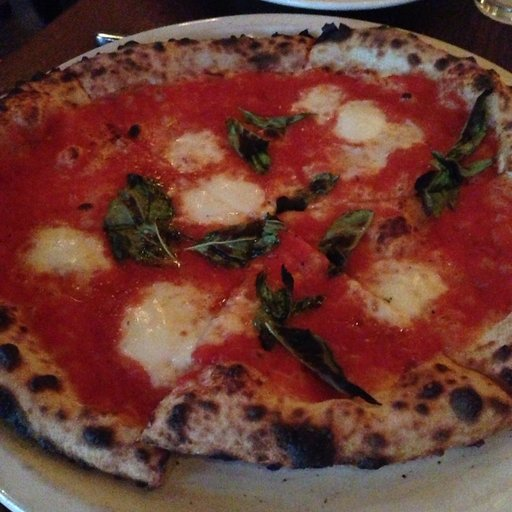

In [9]:
import random
from PIL import Image

# Set seed
# random.seed(42)

# 1. Get all image paths
image_path_list=list(image_path.glob("*/*/*.jpg"))

# glob is generally used to stick all the path together

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)
print(random_image_path)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_Class = random_image_path.parent.stem
print(image_Class)

# 4. Open image
img = Image.open(random_image_path)

# 5. print metadata
print(f"Random image path:{random_image_path}")
print(f"Image class: {image_Class}")
print(f"Image height:{img.height}")
print(f"Image width:{img.width}")
img



(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

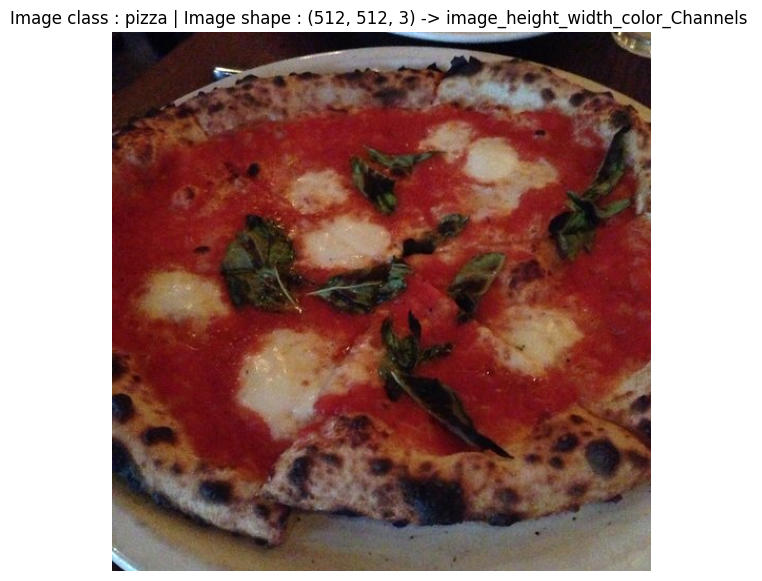

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class : {image_Class} | Image shape : {img_as_array.shape} -> image_height_width_color_Channels ")
plt.axis(False)



## 3 . Transforming data

Before we can use our image data with Pytorch:
1. Turn your target data into tensors ( in our case, numerical representation of our images).
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`


In [11]:
from torch.utils.data import DataLoader
from torchvision import datasets,transforms


### 3.1 Transforming data with `torchvision.transforms`

Transforms help you get your images ready to be used with a model/perform data augmentation

In [12]:
# Write a transform for image
 # we can also use nn.Sequential
data_transform = transforms.Compose  ([
    # Resize our images to 64x64
    transforms.Resize(size=(64,64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into a tensor.Tensor
    transforms.ToTensor()
])


In [13]:
data_transform(img).shape

torch.Size([3, 64, 64])

In [14]:
data_transform(img).dtype

torch.float32

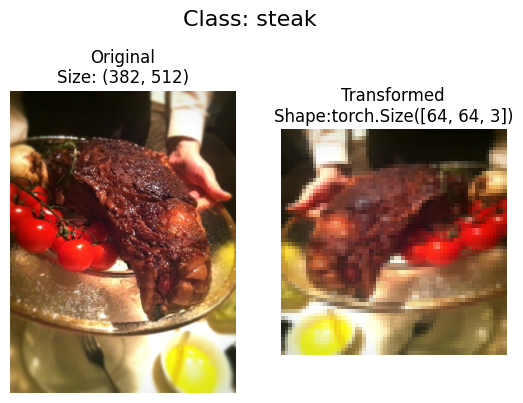

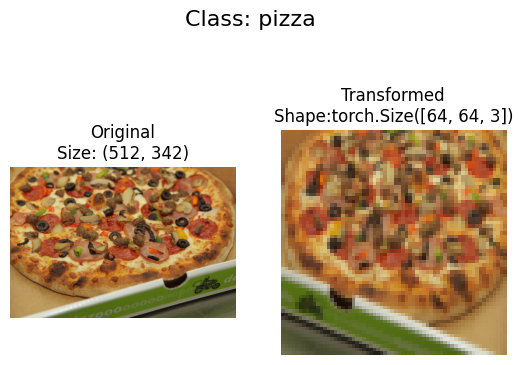

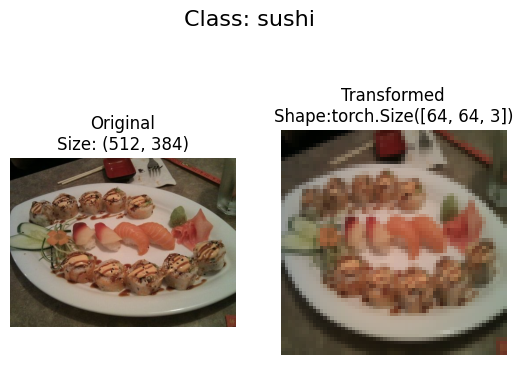

In [15]:
def plot_transformed_images(image_paths: list,transform,n=3,seed=42):
  """
  selects random images from a path of images and loads/transforms
  them then plot the original vs the transformed version

  """
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths,k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1,ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)


      # Transform and plot target image
      transformed_image = transform(f).permute(1,2,0) # note we will needd to change shape for matplotlib (C,H,W) -> (H,W,C)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nShape:{transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}" , fontsize=16)


plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=None

                        )

In [16]:
# image_path_list

## 4 . option 1 : Loading image data into `ImageFolder`

We can load image classification data using torchvision.datasets.ImageFolder


In [17]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data=datasets.ImageFolder(root=train_dir,
                                transform=data_transform, # a transform for the data
                                target_transform=None # a transform for target

                                )

test_data=datasets.ImageFolder(root=test_dir,
                               transform=data_transform
                               )

train_data, test_data


(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [18]:
train_dir , test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [19]:
# Get class name as list
class_name = train_data.classes
class_name

['pizza', 'steak', 'sushi']

In [20]:
# Get class name as dict
class_dict=train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [21]:
# Check the lengths of out datasets
len(train_data), len(test_data)

(225, 75)

In [22]:
train_data.samples[0]

('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0)

In [23]:
# Index on the train_data Dataset to get a single image and label
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n {img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label:{label}")
print(f"Label dtype : {type(label)} ")

Image tensor:
 tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.0

In [24]:
class_name[label]

'pizza'

Original shape:torch.Size([3, 64, 64]) -> [color_channels,height,width]
Image permute:torch.Size([64, 64, 3])


Text(0.5, 1.0, 'pizza')

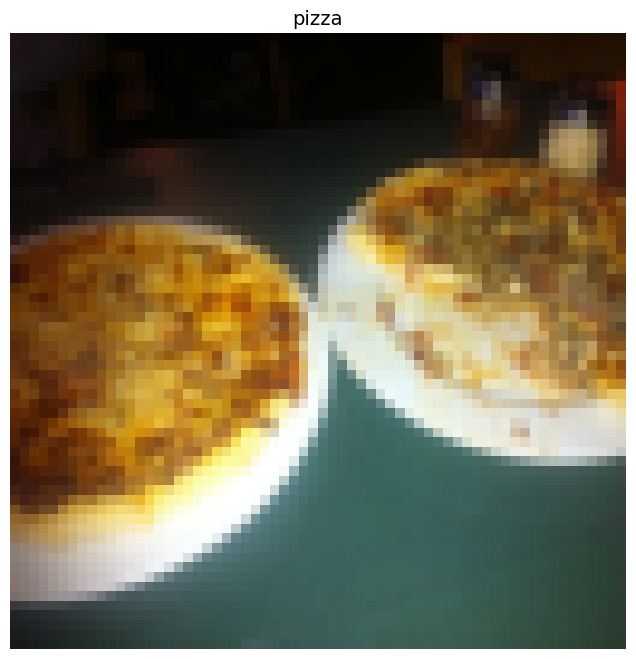

In [25]:
# Rearrange the order dimensions
img_permute = img.permute(1,2,0)

# Print out different shapes
print(f"Original shape:{img.shape} -> [color_channels,height,width]")
print(f"Image permute:{img_permute.shape}")

# Plot the image
plt.figure(figsize=(10,8))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_name[label],fontsize=14)


### 4.1 Turn loaded images into `DataLoader`

A `DataLoader` is going to help us turn our `Dataset`'s into iterables and we can customise the `batch_size` so our model can see batch_size images at a time

In [26]:
import os
os.cpu_count()

2

In [27]:
# Turn train and test datasets into DataLoader's
from torch.utils.data import DataLoader
BATCH_SIZE=32
train_dataloader=DataLoader(dataset=train_data,
                            batch_size=BATCH_SIZE,
                            # num_workers=os.cpu_count()
                            num_workers=1,
                            shuffle=True
                            )
test_dataloader=DataLoader(dataset=test_data,
                           batch_size=BATCH_SIZE,
                           num_workers=1,
                           shuffle=False
                           )

train_dataloader,test_dataloader




(<torch.utils.data.dataloader.DataLoader at 0x7d95ef8081d0>,
 <torch.utils.data.dataloader.DataLoader at 0x7d95f0006540>)

In [28]:
len(train_dataloader),len(test_dataloader)

(8, 3)

In [29]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1 you can change the batch size if you like
print(f"Image shape : {img.shape} -> [batch_size,color_channels,height,width]")
print(f"Label shape:{label.shape}")


Image shape : torch.Size([32, 3, 64, 64]) -> [batch_size,color_channels,height,width]
Label shape:torch.Size([32])


## 5 . Option 2 :  Loading Image Data with a Custom `Dataset`

1. Want to be able to load images from file
2. Want to be able to get class names from the Dataset
3. Want to be able to get classes as dictionary from the Dataset

Pros:
* Can create a `Dataset` out of almost anything
* Not limited to Pytorch pre-built `Dataset` functions

Cons:
* Even though you could create `Dataset` out of almost anything. it doesn't mean it will work....
* Using a custom `Dataset` often results in us writing more code, which could be prone to errors or performance issues



In [30]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple,Dict,List


In [31]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names

we want to function to:
1. Get the cass names using `os.scandir()` to traverse a target directory (ideally the directory is in standard image classification format)
2. Raise an error if the class name aren't found (if this happens, there might be something wrong with the directory structure)
3. Turn the class names into a dict and a list and return them

In [32]:
# Setup path for target directory
target_directory=train_dir
print(f"Target dir : {target_directory}")

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found


Target dir : data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [33]:
list(os.scandir(target_directory))

[<DirEntry 'sushi'>, <DirEntry 'pizza'>, <DirEntry 'steak'>]

In [34]:
def find_classes(directory:str)-> Tuple[List[str],Dict[str,int]]:
  """Finds the classes folder names in a target directory."""
  # 1 Get the class names by scanning the target directory
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  # 2 Raise an error if class names could not be found
  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in {directory}....Please check file structure")

  # 3 Create a dictionary of index abels (computers prefer number)
  class_to_idx = {class_name: i for i, class_name in enumerate(classes)}

  return classes,class_to_idx

In [35]:
find_classes(test_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom `Dataset` to replicate  `ImageFolder`

 To create our own custom dataset, we want to :   

 1. Subclass `torch.utils.data.Dataset`
 2. Init our subclass with target directory (the directory we'd like to get data from ) as well as a transform if we'd like to transform our data.
 3. Create several attributes:
    * paths - paths of our images
    * transform - the tranform we'd like to use
    * classes - a list of the target classes
    * class_to_idx - a dict of the target classes mapped to integer labels
 4. Create a function to `load_images()` , this function will open an image
 5. Overwrite the `__len()__` method to return the length of our dataset
 6. Overwrite the `__getitem()__`method to return a given sample when passed an index


In [36]:
# 1 Write a custom dataset class
from torch.utils.data import Dataset

class ImageFolderCustom(Dataset):
  # 2 Initialize our custom dataset
  def __init__(self,
               targ_dir:str,
               transform=None
               ):
    # 3 Create class attributes
    # Get all of the immage paths
    self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
    # Setup transforms
    self.transform = transform
    # Create classes and class_to_idx attricbutes
    self.classes,self.class_to_idx = find_classes(targ_dir)

    # 4 Create a function to load images
  def load_image(self,index:int)->Image.Image:
      """Opens an image via a path and returns it."""
      image_path = self.paths[index]
      return Image.open(image_path)

    # 5 overwrite __len__()
  def __len__(self)-> int:
      "Return the total number of samples"
      return len(self.paths)

    # 6 overwrite __getitem__() method to return a particular sample
  def __getitem__(self,index:int)->Tuple[torch.Tensor,int]:
      """ Returns one sample of data, data and label (X,y)"""
      img = self.load_image(index)
      class_name = self.paths[index].parent.name # expects path in format: data_folder/class_name/image.jpg
      class_idx = self.class_to_idx[class_name]

      # Transform if necessary
      if self.transform:
        return self.transform(img),class_idx # return data, label (X,y)
      else:
        return img, class_idx # return untransformed image and label



In [37]:
# create a transform
from torchvision import transforms
train_transforms = transforms.Compose([
                                      transforms.Resize(size=(64,64)),
                                      transforms.RandomHorizontalFlip(p=0.5),
                                      transforms.ToTensor()
                                    ])

test_transforms = transforms.Compose([
                                      transforms.Resize(size=(64,64)),
                                      transforms.ToTensor()

                                    ])

In [38]:
# Test out ImageFolderCustom
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms
                                      )

test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                     transform=test_transforms
                                     )

train_data_custom,test_data_custom

(<__main__.ImageFolderCustom at 0x7d95ef8729f0>,
 <__main__.ImageFolderCustom at 0x7d95ef9484a0>)

In [39]:
len(train_data), len(train_data_custom)

(225, 225)

In [40]:
len(test_data), len(test_data_custom)

(75, 75)

In [41]:
train_data_custom.classes ,test_data_custom.classes

(['pizza', 'steak', 'sushi'], ['pizza', 'steak', 'sushi'])

In [42]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [43]:
# Check fr equality between original ImageFolder Dataset and ImageFolderCustom Dataseet
print(train_data_custom.classes== train_data.classes)
print(test_data_custom.classes==test_data.classes)

True
True


### 5.3 Create a function to display random images

1. Take in a `Dataset` and a number of other parameters such as class names and how many images to visualize
2. To prevent the display getting out of hand, let's cap the number of images to see at 10.
3. Set the random seed for resproducibility
4. Get a list of random sample indexes from the target dataset.
5. Setup a matplotlib plot.
6. Loop through the random sample indexes and plot them with matplotlib
7. Make sure the dimensiions of our images line up with matplotlib(HWC)


In [44]:
from IPython.core.pylabtools import figsize
# 1. Create a function to take in a dataset
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes:List[str]=None,
                          n:int=10,
                          display_shape:bool=True,
                          seed:int=None
                          ):
  # 2 Adjust display if n is too high
  if n > 10:
    n = 10
    display_shape = False
    print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display")

  # 3 Set the seed
  if seed:
    random.seed(seed)

  # 4 Get random sample indexes
  random_sample_idx = random.sample(range(len(dataset)),k=n)

  # 5 setup plot (create figure and subplots once)
  fig, axs = plt.subplots(1, n, figsize=(16,8))


  # 6 Loop through random indexes and plot them with matplotlib
  for i,targ_sample in enumerate(random_sample_idx):
    targ_image,targ_label = dataset[targ_sample][0] , dataset[targ_sample][1]

    # 7 Adjust tensor dimensions for plotting
    targ_image_adjust = targ_image.permute(1,2,0) # height,width,color_channels

    axs[i].imshow(targ_image_adjust)
    axs[i].axis("off")
    if classes:
      title = f"class:{classes[targ_label]}"
      if display_shape:
        title = title + f"\nshape:{targ_image_adjust.shape}"
      axs[i].set_title(title)
  plt.tight_layout()

In [45]:
random.sample(range(len(test_data_custom)),k=5)

[20, 3, 62, 25, 67]

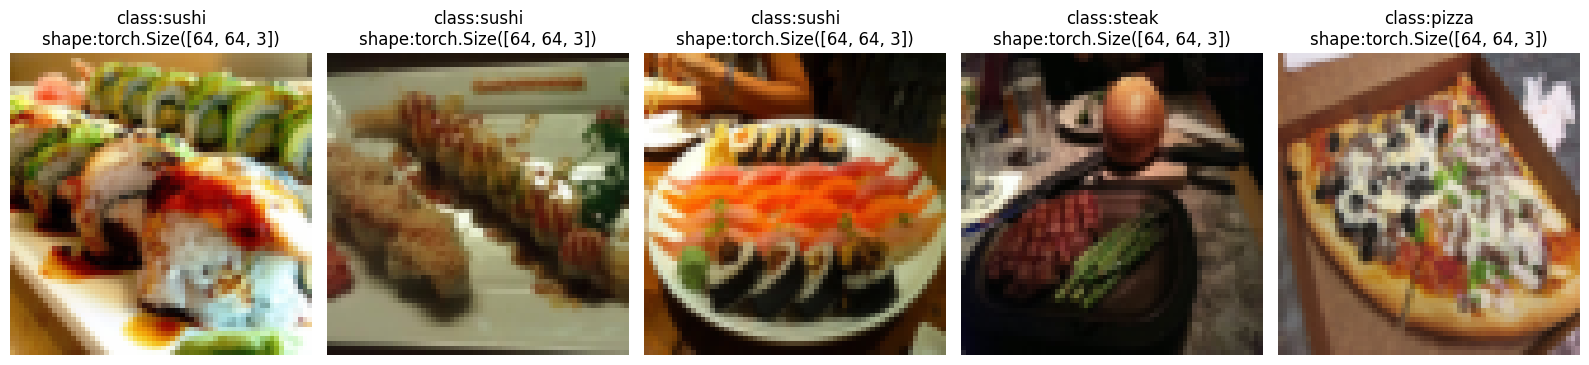

In [46]:
# Display random images from the ImageFolder created Dataset
display_random_images(train_data,
                      n=5,
                      classes=class_name,
                      seed=None
                      )

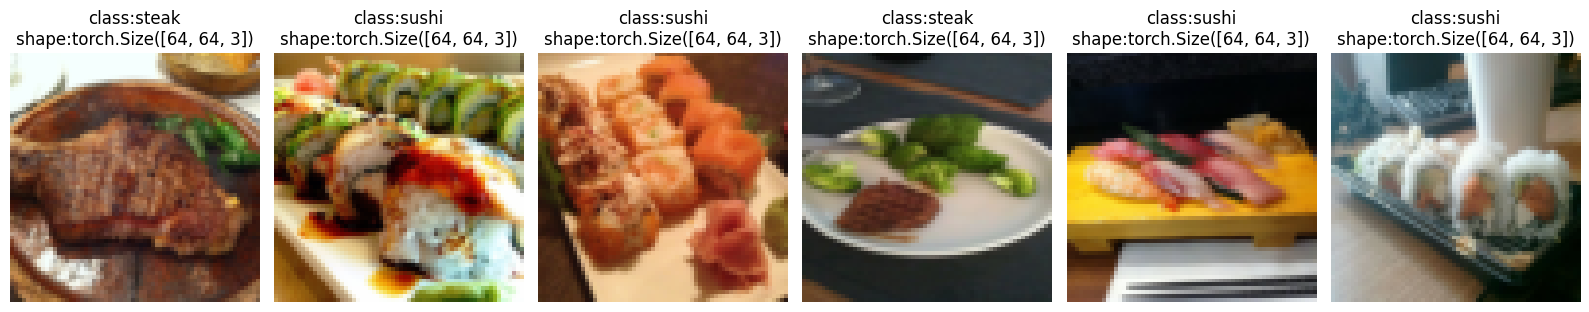

In [47]:
# Display random images from the ImageFolderCustom Dataset
display_random_images(train_data_custom,
                      n=6,
                      classes=class_name,
                      seed=42
                      )

### 5.4 Turn custom loaded images into DataLoader's

In [48]:
from torch.utils.data import DataLoader
BATCH_SIZE=32
NUM_WORKERS=0
train_dataloader_custom= DataLoader(dataset=train_data_custom,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=True
                              )

test_dataloader_custom = DataLoader(dataset=test_data_custom,
                              batch_size=BATCH_SIZE,
                              num_workers=os.cpu_count(),
                              shuffle=False
                              )

train_dataloader_custom, test_dataloader_custom




(<torch.utils.data.dataloader.DataLoader at 0x7d95ef56c320>,
 <torch.utils.data.dataloader.DataLoader at 0x7d95f0b35040>)

In [49]:
# Get image and labeel from custom dataloader
img_custom,label_custom = next(iter(train_dataloader_custom))

In [50]:
img_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [51]:
img,label=train_data[0]

In [52]:
img,label

(tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
          [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
          [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
          ...,
          [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
          [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
          [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],
 
         [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
          [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
          [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
          ...,
          [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
          [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
          [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],
 
         [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
          [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
          [0.0902, 0.0902, 0.0902,  ...,

## 6 . Other forms of transform (Data Augmentation)

Data augmentation is the process of artificially adding diversity to your training data.

In case of Image data, this may mean applying various image transformations to the training images.

This practice hopefully results in a model that's more generalizable to unseen data.

Let's take a look at one particular type of data augmentation used to train Pytorch vision models to state of the art levels....

Blog post


In [53]:
# Let's look at trivial augment
from torchvision import transforms

train_transform = transforms.Compose([
                                      transforms.Resize(size=(224,224)),
                                      transforms.TrivialAugmentWide(num_magnitude_bins=5),
                                      transforms.ToTensor()

                                    ])

test_transforms = transforms.Compose([
                                      transforms.Resize(size=(224,224)),
                                      transforms.ToTensor()

                                      ])

In [54]:
# Get all image paths
image_path_list=list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

[PosixPath('data/pizza_steak_sushi/test/sushi/2540511.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/175783.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/1742201.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/1172255.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/2394442.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/1680893.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/988559.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/499605.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/2276986.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/1987407.jpg')]

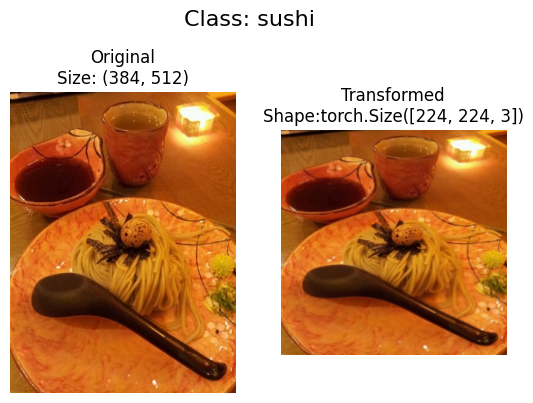

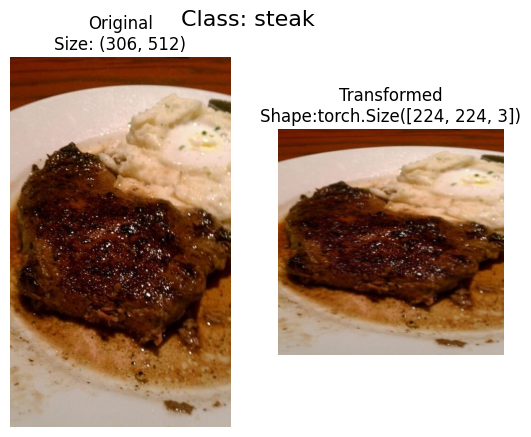

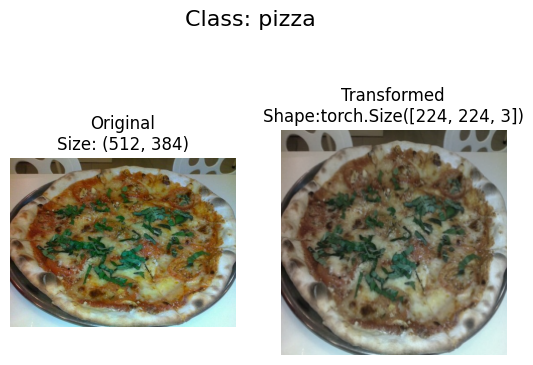

In [55]:
# Plot random transformed images
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transform,
    n=3,
    seed=None
)



## 7 . Model 0 Training the model without data augmentation

Let's replicate TinyVGG architecture from the CNN explainer

### 7.1 Creating transforms and looking data for Model 0

In [56]:
simple_transform = transforms.Compose([
                                      transforms.Resize(size=(64,64)),
                                      transforms.ToTensor()
                                      ])

In [57]:
# 1. Load and transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir,
                                         transform=simple_transform
                                         )
test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=simple_transform
                                        )

# Turn the datasets into dataLoaders
import os
from torch.utils.data import DataLoader

#Setup batch size and number of works
BATCH_SIZE=32
NUM_WORKERS=os.cpu_count()

# Create DataLoader's
train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=NUM_WORKERS
                                    )
test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    shuffle=False,
                                    num_workers=os.cpu_count()
                                    )

In [58]:
train_dataloader_simple,test_dataloader_simple

(<torch.utils.data.dataloader.DataLoader at 0x7d96286547a0>,
 <torch.utils.data.dataloader.DataLoader at 0x7d95ef94bf20>)

In [59]:
# train_data_simple[1]

### 7.2 Create TinyVGG model class

In [60]:
class TinyVGG(nn.Module):
  """
  Model architecture copying TinyVGG from CNN Explainer
  """
  def __init__(self,input_shape:int,
               hidden_units:int,
               output_shape:int
               ):
    super().__init__()

    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0
                  ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2
                     ) # default stride value is same as kernel_size
                       )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0
                  ),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0
                  ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2) # default stride value is same as kernel size
    )

    self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*13*13,
                      out_features=output_shape
                      )
    )

  def forward(self,x):
      x=self.conv_block_1(x)
      print(x.shape)
      x=self.conv_block_2(x)
      print(x.shape)
      x=self.classifier(x)
      print(x.shape)
      return x






In [61]:
torch.manual_seed(42)
model_0=TinyVGG(input_shape=3,
                hidden_units=10,
                output_shape=len(class_name)
                ).to(device)

model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

### 7.3 Try a forward pass on a single image (to test the model)


In [62]:
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape,label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [63]:
# Try a forward pass
model_0(image_batch.to(device))

torch.Size([32, 10, 30, 30])
torch.Size([32, 10, 13, 13])
torch.Size([32, 3])


tensor([[ 2.0795e-02, -1.9510e-03,  9.5212e-03],
        [ 1.8440e-02,  2.4668e-03,  6.6609e-03],
        [ 1.7695e-02,  1.0282e-03,  9.4975e-03],
        [ 2.4446e-02, -3.3489e-03,  9.5877e-03],
        [ 1.9939e-02,  6.9131e-04,  1.0778e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0046e-03],
        [ 2.0996e-02,  1.6415e-04,  1.2481e-02],
        [ 2.1566e-02, -1.9607e-03,  9.7175e-03],
        [ 2.4500e-02, -4.7904e-03,  8.5394e-03],
        [ 2.0239e-02, -4.7979e-04,  1.0907e-02],
        [ 2.2219e-02, -4.1816e-04,  9.8173e-03],
        [ 2.2318e-02, -2.1642e-03,  9.4428e-03],
        [ 2.1851e-02, -3.7225e-03,  8.3784e-03],
        [ 2.2881e-02, -1.7559e-03,  1.0299e-02],
        [ 2.1635e-02, -4.3995e-03,  9.4990e-03],
        [ 2.2101e-02, -4.1469e-03,  9.3904e-03],
        [ 2.1226e-02, -4.4215e-03,  1.1476e-02],
        [ 2.1698e-02, -2.7458e-03,  8.4966e-03],
        [ 1.9974e-02, -3.1665e-07,  8.4496e-03],
        [ 1.8308e-02,  1.6378e-03,  8.5491e-03],
        [ 2.0768e-02

### 7.4 Use `torchinfo` to get an idea of the shapes going through our model



In [64]:
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
# summary(model_0,input_Size=[1,3,64,64])

batch_size = 1
summary(model_0, input_size=(batch_size, 3, 64, 64),
col_names=("input_size", "output_size", "num_params")
)

torch.Size([1, 10, 30, 30])
torch.Size([1, 10, 13, 13])
torch.Size([1, 3])


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
TinyVGG                                  [1, 3, 64, 64]            [1, 3]                    --
├─Sequential: 1-1                        [1, 3, 64, 64]            [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 3, 64, 64]            [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 62, 62]           [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 60, 60]           [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 30, 30]           [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 30, 30]           [1, 10, 28, 28]           910
│    └─ReLU: 2-7                

## 7.5 Create train and test loops functions

* `train_step()` - takes in a model and dataloader and trains the model on the dataloader

* `test_step()` - takes in a model and dataloader and evaluates the model on the dataloader

In [65]:
# Create train_Step()
def train_step(model:torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer:torch.optim.Optimizer,
               device=device

               ):
  # Put the model in train model
  model.train()

  # setup train loss and train accuracy values
  train_loss, train_acc = 0,0

  # Loop through data
  for batch,(X,y) in enumerate(dataloader):
    # send data to the target device
    X,y=X.to(device), y.to(device)

    # 1. Forward pass
    y_pred = model(X) # output model logits

    # 2 Calculate the loss
    loss=loss_fn(y_pred,y)
    train_loss+=loss.item()

    # 3 optimizer zero grad
    optimizer.zero_grad()

    # 4 Loss backward
    loss.backward()

    # 5 Optimizer step
    optimizer.step()

    # Calculate accuracy metric
    y_Pred_Class = torch.argmax(torch.softmax(y_pred,dim=1),dim=1)
    train_acc+= (y_Pred_Class==y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss/len(dataloader)
  train_acc = train_acc/len(dataloader)
  return train_loss,train_acc

In [66]:
# Create a test step
def test_step(model:torch.nn.Module,
              dataloader:torch.utils.data.dataloader,
              loss_fn:torch.nn.Module,
              device=device
              ):

  # Put model in eval mode
  model.eval()

  # Setup the test loss and test accuracy values
  test_loss, test_Acc=0, 0

  # Turn on inference model
  with torch.inference_mode():
    # Loop through DataLoader batches
    for batch,(X,y) in enumerate(dataloader):
      # Send data to the target device
      X, y = X.to(device), y.to(device)

      # Forward pass

      test_pred_logits= model(X)

      # 2 Calculate the loss
      loss = loss_fn(test_pred_logits,y)
      test_loss+=loss.item()

      # 3 calculate the accuracy
      test_pred_labels=test_pred_logits.argmax(dim=1)
      test_Acc+=((test_pred_labels==y).sum().item()/len(test_pred_labels))


  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss/len(dataloader)
  test_Acc=test_Acc/len(dataloader)

  return test_loss,test_Acc




### 7.6 Creating a `train()` function to combine `train_Step()` and `test_step()`

In [67]:
from tqdm.auto import tqdm

# 1 Create a train function that takes in various model parameters + optimizer + data augmentation
def train(model:torch.nn.Module,
          train_dataloader:torch.utils.data.DataLoader,
          test_dataloader:torch.utils.data.DataLoader,
          optimizer:torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device=device):

  # 2 Create empty results dictionary
  results ={"train_loss":[],
            "train_Acc":[],
            "test_loss":[],
            "test_Acc":[]
                        }
  # 3 Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    train_loss, train_Acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device

                                       )
    test_loss,test_Acc= test_step(model=model,
                                  dataloader=test_dataloader,
                                  loss_fn=loss_fn,
                                  device=device

                                  )

    # 4 Print out what's happening
    print(f"Epoch:{epoch} | Train loss: {train_loss:.4f} | Train_Acc:{train_Acc:.4f} | Test loss : {test_loss:.4f} | Test Acc :{test_Acc:.4f}")

    # 5 Update result dictionary
    results["train_loss"].append(train_loss)
    results["train_Acc"].append(train_Acc)
    results["test_loss"].append(test_loss)
    results["test_Acc"].append(test_Acc)

    # 6 Return the filled results at the end
  return results

### 7.7 Train and evaluate the model

In [68]:
# set the random seeds
torch.manual_seed(84)
torch.cuda.manual_seed(84)

# Set number of epochs
NUM_EPOCHS = 5

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data.classes)
                  ).to(device)

# Setup loss function and optimizer
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(params=model_0.parameters(),
                           lr=0.001
                           )

# Start the timer
from timeit import default_timer as timer
start_time=timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS

                        )

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time:{end_time-start_time:.3f} seconds")



  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([32, 10, 30, 30])
torch.Size([32, 10, 13, 13])
torch.Size([32, 3])
torch.Size([32, 10, 30, 30])
torch.Size([32, 10, 13, 13])
torch.Size([32, 3])
torch.Size([32, 10, 30, 30])
torch.Size([32, 10, 13, 13])
torch.Size([32, 3])
torch.Size([32, 10, 30, 30])
torch.Size([32, 10, 13, 13])
torch.Size([32, 3])
torch.Size([32, 10, 30, 30])
torch.Size([32, 10, 13, 13])
torch.Size([32, 3])
torch.Size([32, 10, 30, 30])
torch.Size([32, 10, 13, 13])
torch.Size([32, 3])
torch.Size([32, 10, 30, 30])
torch.Size([32, 10, 13, 13])
torch.Size([32, 3])
torch.Size([1, 10, 30, 30])
torch.Size([1, 10, 13, 13])
torch.Size([1, 3])
torch.Size([1, 10, 30, 30])
torch.Size([1, 10, 13, 13])
torch.Size([1, 3])
torch.Size([1, 10, 30, 30])
torch.Size([1, 10, 13, 13])
torch.Size([1, 3])
torch.Size([1, 10, 30, 30])
torch.Size([1, 10, 13, 13])
torch.Size([1, 3])
torch.Size([1, 10, 30, 30])
torch.Size([1, 10, 13, 13])
torch.Size([1, 3])
torch.Size([1, 10, 30, 30])
torch.Size([1, 10, 13, 13])
torch.Size([1, 3])
torc

In [69]:
model_0_results

{'train_loss': [1.11215241253376,
  1.1180184036493301,
  1.0681662634015083,
  1.0652256309986115,
  1.0189425498247147],
 'train_Acc': [0.3046875, 0.29296875, 0.47265625, 0.30859375, 0.54296875],
 'test_loss': [1.1103113333384196,
  1.1072753779093425,
  1.0746796123186748,
  1.0743311444918315,
  1.0644332285722096],
 'test_Acc': [0.25333333333333335,
  0.25333333333333335,
  0.3466666666666667,
  0.37333333333333335,
  0.38666666666666666]}

### 7.8 PLot the loss curves of Model 0

**loss Curves** is a way of tracking your models progress over time



In [70]:
# Get the model_0_results key
model_0_results.keys()

dict_keys(['train_loss', 'train_Acc', 'test_loss', 'test_Acc'])

In [71]:
def plot_loss_curves(results: Dict[str,List[float]]):
  """Plots training curves of a results Dictionary"""

  # Get the loss values of the results dictionary (training and test)
  loss = results["train_loss"]
  test_loss = results["test_loss"]

  # Get the accuracy values of the result dictionary (training and test)
  accuracy = results["train_Acc"]
  test_accuracy = results["test_Acc"]

  # FIgure out how many epochs there were
  epochs= range(len(results["train_loss"]))

  # Setup a plot
  plt.figure(figsize=(15,7))

  # PLot the curves
  plt.subplot(1,2,1)
  plt.plot(epochs, loss,label="train_loss")
  plt.plot(epochs,test_loss,label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # PLot the accuracy
  plt.subplot(1,2,2)
  plt.plot(epochs,accuracy,label="train_accuracy")
  plt.plot(epochs,test_accuracy,label="test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()



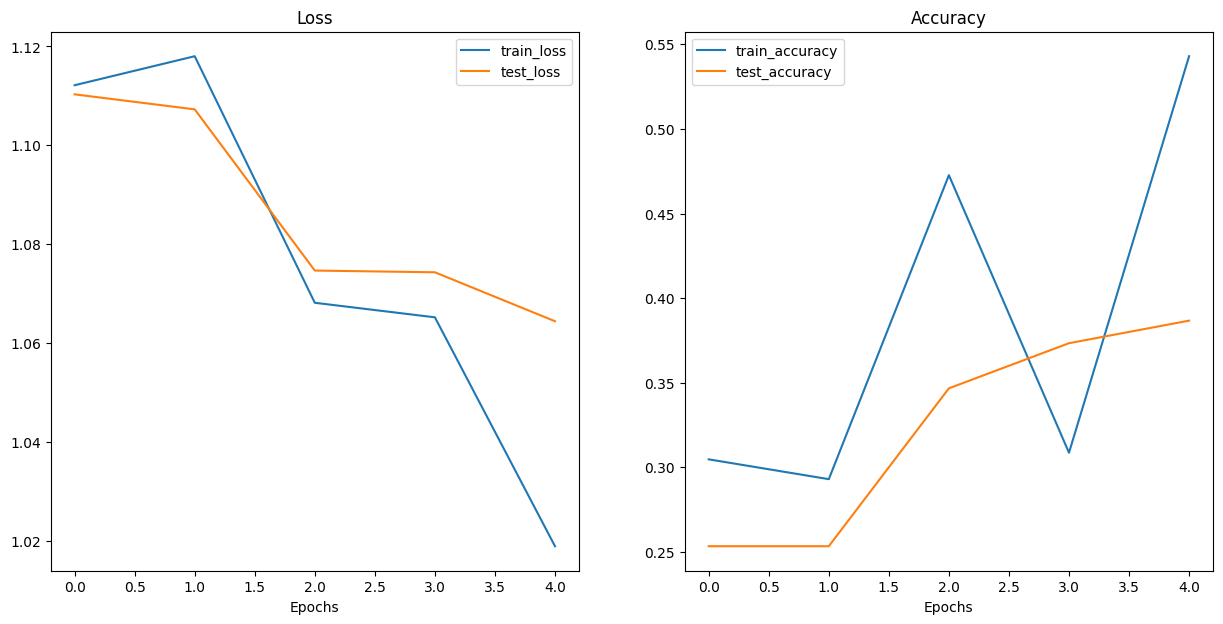

In [72]:
plot_loss_curves(model_0_results)

## 8 . What should an ideal loss curve look like

A loss curve is one most helpful ways to troubleshoot a model

## 9 . Model 1: TinyVGG wth Data Augmentation

Now let's try another modelling experiment this time using the same mode as before with some data augmentation



### 9.1 Create transform with data augmentation

In [73]:
# Create training transform with TrivialAugment
from torchvision import transforms
train_transform_trivial = transforms.Compose([
                                            transforms.Resize(size=(64,64)),
                                            transforms.TrivialAugmentWide(num_magnitude_bins = 31),
                                            transforms.ToTensor()
                                            ])


test_transforms_simple = transforms.Compose([
                                            transforms.Resize(size=(64,64)),
                                            transforms.ToTensor()
                                            ])


### 9.2 Create train and test `Datasets` and `DataLoaders` with data augmentation

In [74]:
# Turn image folders into Datasets
from torchvision import datasets
train_data_augmented = datasets.ImageFolder(root=train_dir,
                                            transform=train_transform_trivial
                                            )

test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform = test_transforms_simple
                                        )


In [75]:
# Turn our Datasets into DataLoaders
import os
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(dataset=train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS
                                        )

test_dataloader_simple =DataLoader(dataset=test_data_simple,
                                   batch_size=BATCH_SIZE,
                                   shuffle=False,
                                   num_workers=NUM_WORKERS
                                  )

### 9.3 Construct and train model 1

This time we'll be using the same model architecture except this time we've augmented the training data.

In [76]:
# Create model_1 and send it to the target device
torch.manual_seed(42)
model_1 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data_augmented.classes)
                  ).to(device)

model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

 Now we've a model and dataloaders, let's create a loss function and an optimizer and call upon our model

In [77]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
NUM_EPOCHS = 5

# Setup loss function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(),
                             lr=0.001
                             )

# Start the timer
from timeit import default_timer as timer
start_time =timer()

# Train model 1
model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS,
                        device=device


                        )

# End the timer and print out how long it took
end_time =timer()
print(f"Total training time for model_1: {end_time-start_time: .3f} seconds")



  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([32, 10, 30, 30])
torch.Size([32, 10, 13, 13])
torch.Size([32, 3])
torch.Size([32, 10, 30, 30])
torch.Size([32, 10, 13, 13])
torch.Size([32, 3])
torch.Size([32, 10, 30, 30])
torch.Size([32, 10, 13, 13])
torch.Size([32, 3])
torch.Size([32, 10, 30, 30])
torch.Size([32, 10, 13, 13])
torch.Size([32, 3])
torch.Size([32, 10, 30, 30])
torch.Size([32, 10, 13, 13])
torch.Size([32, 3])
torch.Size([32, 10, 30, 30])
torch.Size([32, 10, 13, 13])
torch.Size([32, 3])
torch.Size([32, 10, 30, 30])
torch.Size([32, 10, 13, 13])
torch.Size([32, 3])
torch.Size([1, 10, 30, 30])
torch.Size([1, 10, 13, 13])
torch.Size([1, 3])
torch.Size([32, 10, 30, 30])
torch.Size([32, 10, 13, 13])
torch.Size([32, 3])
torch.Size([32, 10, 30, 30])
torch.Size([32, 10, 13, 13])
torch.Size([32, 3])
torch.Size([11, 10, 30, 30])
torch.Size([11, 10, 13, 13])
torch.Size([11, 3])
Epoch:0 | Train loss: 1.1049 | Train_Acc:0.2500 | Test loss : 1.1019 | Test Acc :0.2604
torch.Size([32, 10, 30, 30])
torch.Size([32, 10, 13, 13])

### 9.4 PLot the loss curves of model 1

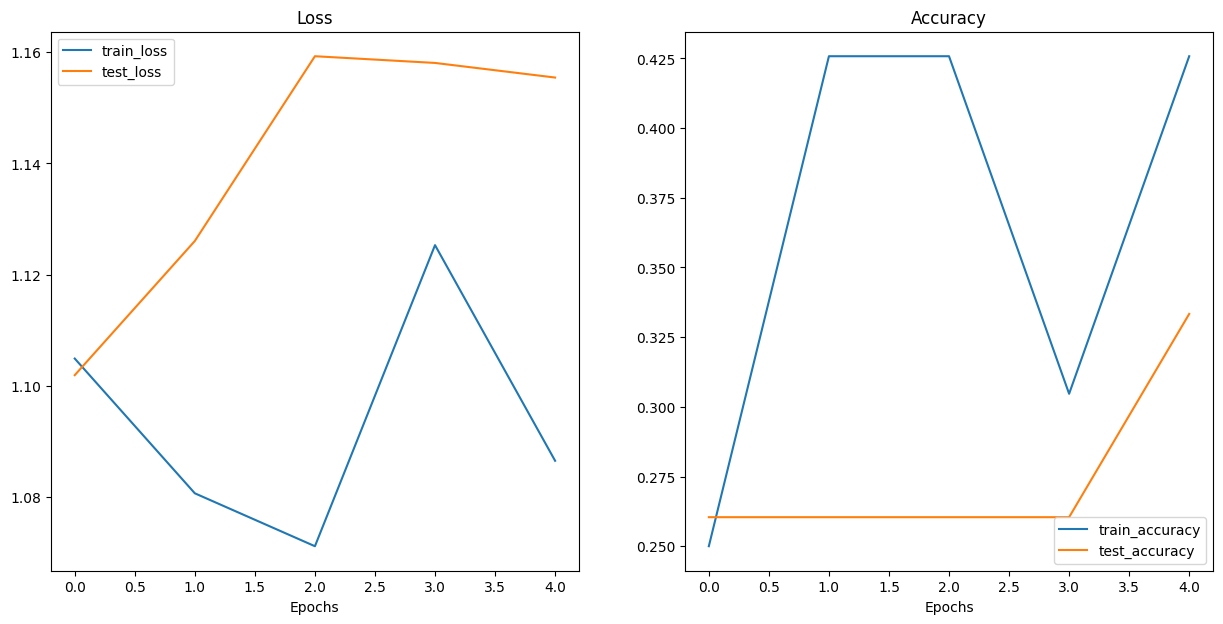

In [78]:
plot_loss_curves(model_1_results)

## 10 . Compare model results

After evaluating our modelling experiments on their own, it's important to compare with each other

In [79]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df

,train_loss,train_Acc,test_loss,test_Acc
0,1.112152,0.304688,1.110311,0.253333
1,1.118018,0.292969,1.107275,0.253333
2,1.068166,0.472656,1.074680,0.346667
3,1.065226,0.308594,1.074331,0.373333
4,1.018943,0.542969,1.064433,0.386667


In [80]:
model_1_df

,train_loss,train_Acc,test_loss,test_Acc
0,1.104914,0.250000,1.101928,0.260417
1,1.080687,0.425781,1.126056,0.260417
2,1.071172,0.425781,1.159275,0.260417
3,1.125308,0.304688,1.158067,0.260417
4,1.086534,0.425781,1.155441,0.333333


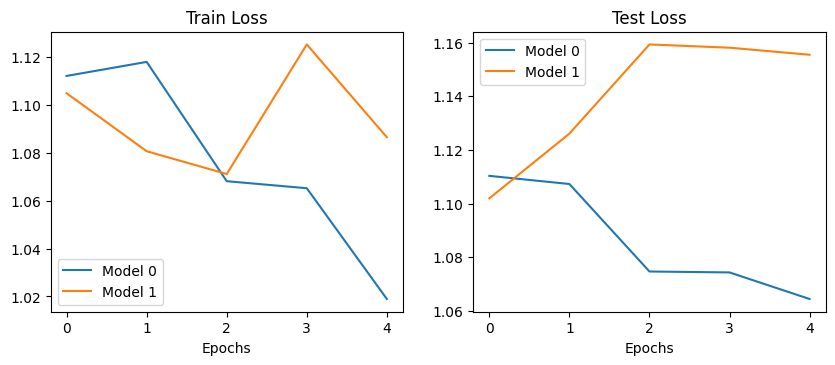

In [81]:
# Setup a plot
plt.figure(figsize=(10,8))

# Get number od epochs
epochs = range(len(model_0_df))

# plot train loss
plt.subplot(2,2,1)
plt.plot(epochs,model_0_df["train_loss"],label="Model 0")
plt.plot(epochs,model_1_df["train_loss"],label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()


# plot test loss
plt.subplot(2,2,2)
plt.plot(epochs,model_0_df["test_loss"],label="Model 0")
plt.plot(epochs,model_1_df["test_loss"],label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

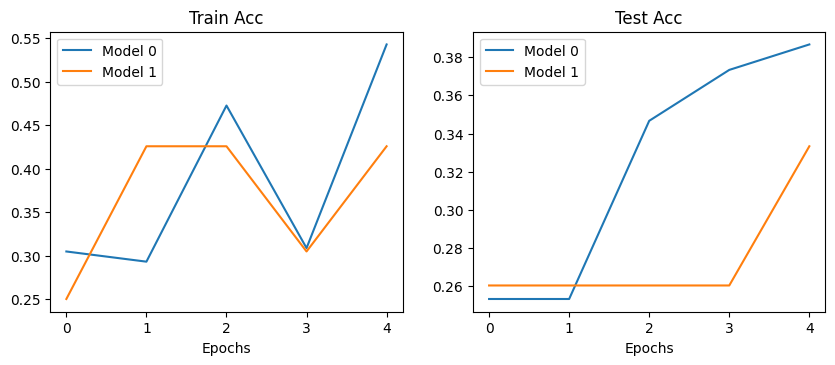

In [82]:
plt.figure(figsize=(10,8))

plt.subplot(2,2,1)
plt.plot(epochs,model_0_df["train_Acc"],label="Model 0")
plt.plot(epochs,model_1_df["train_Acc"],label="Model 1")
plt.title("Train Acc")
plt.xlabel("Epochs")
plt.legend()


# plot test loss
plt.subplot(2,2,2)
plt.plot(epochs,model_0_df["test_Acc"],label="Model 0")
plt.plot(epochs,model_1_df["test_Acc"],label="Model 1")
plt.title("Test Acc")
plt.xlabel("Epochs")
plt.legend()

## 11 . Making a prediction on a custom image

Although we've trained a model on custom data....How do you make a prediction on a sample/Image that's not in either training or testing dataset

In [83]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
  with open(custom_image_path,"wb") as f:
    # When donwloading from Github, need to use the "raw" file link
      request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
      print(f"Downloading {custom_image_path}....")
      f.write(request.content)
else:
  print(f"{custom_image_path} already exists, skipping the download..")


### 11.1 Loading in a custom image with Pytorch

we have to make sure our custom image is in the same format as the data our model was trained on.

* In tensor form with datatype (torch.float32)

* Of Shape 64x64x3

* On the right device

we Can read an image into Pytorch using - torchvision.image

In [84]:
import torchvision

# Read in custom image
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))
print(f"custom image tensor:\n{custom_image_uint8}")
print(f"Custom image shape: {custom_image_uint8.shape}")
print(f"Custom image datatype: {custom_image_uint8.dtype}")


custom image tensor:
tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)
Custom image shape: torch.Size([3, 4032, 3024])
Custom image datat

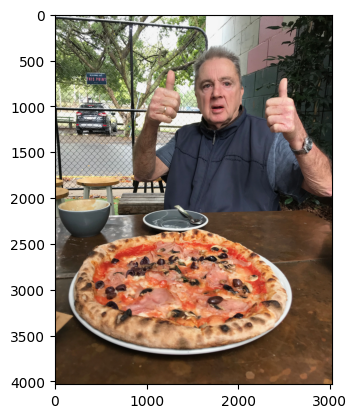

In [85]:
plt.imshow(custom_image_uint8.permute(1,2,0))

### 11.2 Making prediction on a custom image with a trained Pytorch Model

In [86]:
# try to make a prediction on an image in uint8
# model_1.eval()
# with torch.inference_mode():
#   model_1(custom_image_uint8.to(device))


In [87]:
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32) / 255.
custom_image

tensor([[[0.6039, 0.6784, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6471, 0.7098,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6745,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],

        [[0.6706, 0.7451, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
         [0.6392, 0.7137, 0.7569,  ..., 0.0863, 0.0745, 0.0627],
         [0.5529, 0.6392, 0.7216,  ..., 0.0745, 0.0706, 0.0627],
         ...,
         [0.2157, 0.1647, 0.1098,  ..., 0.4196, 0.4078, 0.4039],
         [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4078, 0.4000],
         [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],

        [[0.4667, 0.5412, 0.5765,  ..., 0.0667, 0.0549, 0.0392],
         [0.4353, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
         [0.3412, 0.4353, 0.5333,  ..., 0.0549, 0.0510, 0.

In [88]:
custom_image.shape

torch.Size([3, 4032, 3024])

In [89]:
# try to make a prediction on an image in uint8

# batchsize erorr
# model_1.eval()
# with torch.inference_mode():
#   model_1(custom_image.to(device))

In [90]:
# Create transform pipeline to resize image
from torchvision import transforms
custom_image_transform = transforms.Compose([
                                            transforms.Resize(size=(64,64))

                                            ])

# Transform target image
custom_image_transformed = custom_image_transform(custom_image)
print(f"Original shape: {custom_image.shape}")
print(f"Transformed shape: {custom_image_transformed.shape}")


Original shape: torch.Size([3, 4032, 3024])
Transformed shape: torch.Size([3, 64, 64])


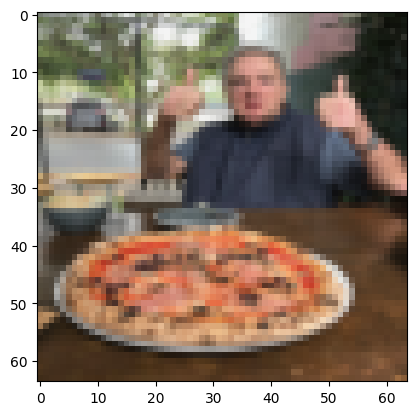

In [91]:
plt.imshow(custom_image_transformed.permute(1,2,0))


In [92]:
# try to make a prediction on an image in uint8
# matrix issues
# model_1.eval()
# with torch.inference_mode():
#   model_1(custom_image_transformed.to(device))

In [93]:
custom_image_transformed.shape,
custom_image_transformed.unsqueeze(0).shape

torch.Size([1, 3, 64, 64])

In [94]:
model_1.eval()
with torch.inference_mode():
  custom_image_pred=model_1(custom_image_transformed.unsqueeze(0).to(device))
custom_image_pred

torch.Size([1, 10, 30, 30])
torch.Size([1, 10, 13, 13])
torch.Size([1, 3])


tensor([[ 0.0781,  0.0379, -0.2067]])

In [95]:
class_name

['pizza', 'steak', 'sushi']

Note, to make a prediction on a custom image we had to:

* Load the image and turn it into a tensor

* Make sure the image was the same datatype as the model (torch.float32)

* Make sure the image was the same shape as the data the model was trained on(3,64,64) with a batch size....(1,3,64,64)

* Make sure the image was on the same device as our model



In [96]:
# Convert logits -> prediction probabilities
custom_image_pred_probs = torch.softmax(custom_image_pred,dim=1)
custom_image_pred_probs

tensor([[0.3686, 0.3541, 0.2773]])

In [97]:
# Convert prediction probabilities -> prediction labels
# Ensure custom_image_pred_probs is at least 2D for dim=1
if custom_image_pred_probs.dim() == 1:
    custom_image_pred_probs = custom_image_pred_probs.unsqueeze(0) # Add a batch dimension if it was lost

custom_image_pred_labels = torch.argmax(custom_image_pred_probs, dim=1)

# Get the predicted class name
predicted_class_idx = custom_image_pred_labels.item()
predicted_class_name = class_name[predicted_class_idx]

print(f"Predicted label index: {predicted_class_idx}")
print(f"Predicted class name: {predicted_class_name}")

Predicted label index: 0
Predicted class name: pizza


### 11.3 Putting custom image prediction together : building a function

Ideal outcome:

A function where we pass an image path to and have our model predict on that image and plot the image + prediction

In [110]:
def pred_and_plot_image(model:torch.nn.Module,
                        image_path:str,
                        class_names:List[str] = None,
                        transform=None,
                        device=device
                        ):
  """ Makes a prediction on a targett image with a trained model and plots the image and predictions."""
  #Load an image
  target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

  # Divide the image pixel values by 255 to get them between [0,1]
  target_image = target_image / 255.

  # Transform if necessary
  if transform:
    target_image = transform(target_image)


  # Make sure the model is on the target device
  model.to(device)

  # Turn on eval/inference mode and make a prediction

  model.eval()
  with torch.inference_mode():
    #Add an extra dimension to the image (this is the batch dimension eg. our model will predict on batches of 1x images )
    target_image = target_image.unsqueeze(0)

    # Make sure a prediction on the image with an extra dimension
    target_image_pred = model(target_image.to(device))

  # Convert logits -> prediction probabiities
  target_image_pred_probs = torch.softmax(target_image_pred,  dim=1)

  # Convert prediction probabilities -> prediction labels
  target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

  # Plot the image alongside the prediction and prediction probability
  plt.imshow(target_image.squeeze().permute(1,2,0)) # remove batch dimension and rearrange shape to be HWC
  if class_names:
    title = f"Pred: {class_names[target_image_pred_label.cpu().item()]} | prob:{target_image_pred_probs.max().cpu().item():.3f}"
  else:
    title = f"pred:{target_image_pred_label.cpu().item()} | prob :{target_image_pred_probs.max().cpu().item():.3f}"
  plt.title(title)
  plt.axis(False)


In [111]:
class_name

['pizza', 'steak', 'sushi']

torch.Size([1, 10, 30, 30])
torch.Size([1, 10, 13, 13])
torch.Size([1, 3])


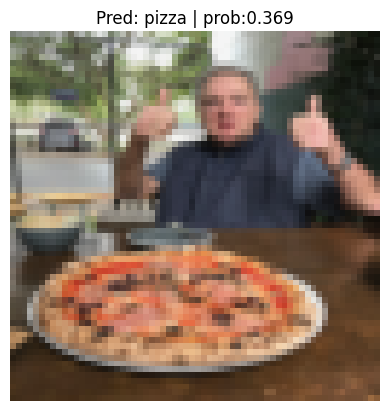

In [114]:
# Pred on our custom image
pred_and_plot_image(model=model_1,
                    image_path=custom_image_path,
                    class_names=class_name,
                    transform=custom_image_transform,
                    device=device

                    )